In [2]:
todays_date = str(datetime.now())[:16] # limit to minutes
display(Markdown(f'##### Date: {todays_date}'))
print(f'detected theme = {current_theme}')
plt.style.use(light_style) 
#plt.style.use(dark_style)

##### Date: 2025-12-19 14:40

detected theme = light


# Sensitivity Anslysis for Reviewer 3
##### Connor van Wieren, 2025

- Although several model parameters, such as where in the basin maximum TOC accumulation occurs, and reaction rate terms, can be varied, these adjustments result in only minor changes to excursion morphology and nadir magnitude.
1. Spatial TOC Peak
2. Reaction Rate

In [4]:
import pandas as pd
from tqdm.notebook import tqdm
import jax
import jax.numpy as jnp
jax.config.update('jax_platform_name', 'cpu')
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection
from matplotlib.cbook import boxplot_stats
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
from cycler import cycler
import seaborn as sns
import pandas as pd 
import time
import os
from scipy import signal
from scipy.stats import norm, uniform, gaussian_kde
from scipy.ndimage import uniform_filter1d
from scipy.ndimage import gaussian_filter
from scipy.stats import spearmanr
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import rasterio
import pickle
import dill
import sys
import string

# stuff for map
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
from cartopy.io import shapereader as shpreader
from shapely.geometry import box
from rasterio.transform import rowcol

matplotlib.rcParams['pdf.fonttype'] = 42  # for acrobat? idk why i need this

# load funcs from .py files
sys.path.insert(0, '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/sed_transport/sed_transport')
from model_dev import run
from utils import *
from output import Model_output

# import facies
sys.path.insert(0, '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/shuram_TOC/code/')
from facies import facies

# interactive plots
from ipywidgets import interactive, interact
from IPython.display import clear_output, Video

sns.set_context('paper')

# data
data_dir = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/shuram_TOC/data/'

# figures
fig_dir = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/shuram_TOC/figures/'
tex_fig_dir = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/Publications/PhD/Ch3_Shuram_TOC_EPSL/img/'
diss_fig_dir = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/vanWieren_Dissertation25/img/ch3/'

# Model 1: TOC and Carbonates: 
- Aim: scale to 20Myr run time (200,000 steps of dt = 0.1, 20,000 timesteps each of 1kyr = 20,000,000 duration)

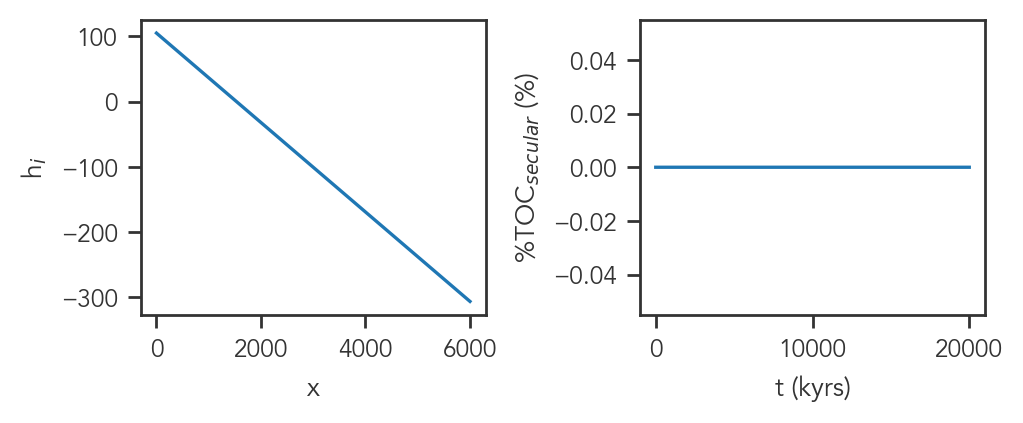

In [5]:
# from the current method
p1 = {'Nx':400,       
      'xmin':0, 
      'xmax':6000,     
      'dx':0.8,
      'start':0,
      'dt':0.1,
      'total_n':2000,
      'compiled_steps':100,
      'ep':-25,
      'org_epsilon': 0,
      'pel_epsilon':0,
      'alg_epsilon':0, 
      'coral_epsilon':0,
      'ocean_depth':0,  
      'org_coef':1,
      'alg_coef':1, 
      'marine_K':2.5e-1,
      'land_K':5e-1,  # 5e-1; 0.85e-1
      'smooth_K':6, # 6      
      'grid_ylen':1000,  # 1000
      'A':0.1,
      'f_react':0.00001,
      'tau':0.033,
      'base_depth':10,
      'toc_t_cutoff':250, # 250 # 2700; 1800; 2500 # prevent weird eroded wedge at start; no TOC accumulation for first 2500kyrs  
     }
x,t,end = init_vars(p1) # time in kyrs

# secular w array - want no change here
seawater = 0 # % TOC
sec_w_fun = lambda t: jnp.ones_like(t) * seawater

## Define h: initial topographic composition
hi = -0.0685*x+105

fig,ax = plt.subplots(1,2,figsize=(5,2),layout='constrained')

# initial proxy and topography
ax[0].plot(x,hi,label='h$_i$')
ax[0].set_xlabel('x')
ax[0].set_ylabel('h$_i$')

# proxy over time
ax[1].plot(t,sec_w_fun(t))
ax[1].set_ylabel(r'%TOC$_{secular}$ (%)')
ax[1].set_xlabel('t (kyrs)');

## RSL Curve

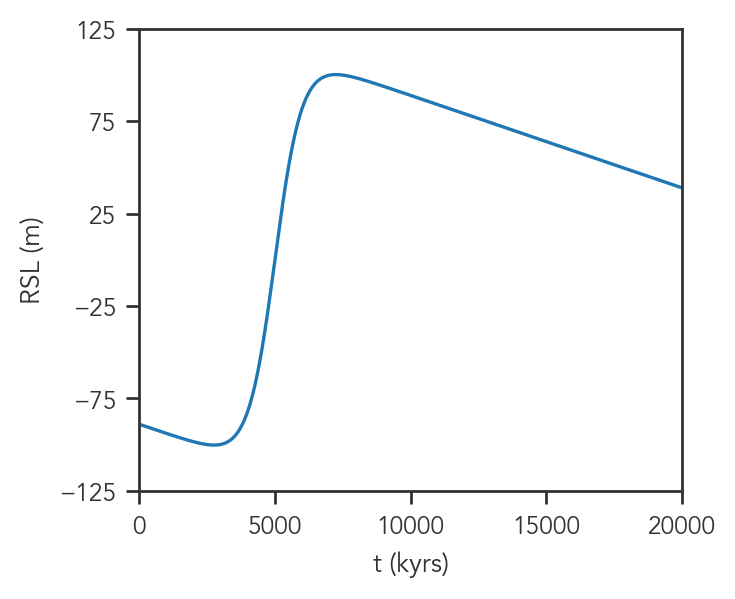

In [6]:
def sl_shuram(t, amp=250, cfall=0.01, center=5000, tau=0.002,
              flat_before_rise=False, flat_buffer=0,
              start_at_transgression=False, shift_time=None):
    """
    Sea level curve to generate Shuram excursion

    Parameters
    ----------
    t : array
        Time array (in kyr)
    amp : float
        Amplitude of the transgression
    cfall : float
        Rate of sea level fall (m/kyr)
    center : float
        Time of maximum transgression (kyr)
    tau : float
        Sigmoid steepness
    flat_before_rise : bool
        If True, flatten sea level before the rise
    flat_buffer : float
        Duration (kyr) to flatten before transgression
    start_at_transgression : bool
        If True, auto-shift so transgression rise starts at t = 0
    shift_time : float or None
        Optional manual time shift (in kyr); overrides auto-shift
    """
    if shift_time is not None:
        t_adj = t + shift_time
    elif start_at_transgression:
        t_adj = t + (0 - (center - 1 / tau))  # auto-shift to move rise to t = 0
    else:
        t_adj = t

    rise = amp / (1 + jnp.exp(-tau * (t_adj - center)))
    fall = -cfall * (t_adj - center)
    sl = rise + fall - amp / 2

    if flat_before_rise:
        t_flat = center - flat_buffer
        min_val = jnp.min(sl * (t_adj < t_flat))  # masked min
        sl = jnp.where(t_adj < t_flat, min_val, sl)

    return sl

# sea level
fig,ax = plt.subplots(figsize=(3.5,3))

ax.set_ylabel('RSL (m)')
ax.set_xlabel('t (kyrs)')
ax.set_xlim(0,20000)
ax.set_ylim(-125,125)
ax.set_yticks(np.linspace(-125,125,6));

# shuram-style sea level curve (50 m rise)
sl_fun = lambda t: sl_shuram(t,amp=228,cfall=0.005) 

ax.plot(t, sl_fun(t), label='current',color='tab:blue')

Model time unit:              1 kyr
Max TOC target:               2.00%
Final org/carb max ratio:     0.020408


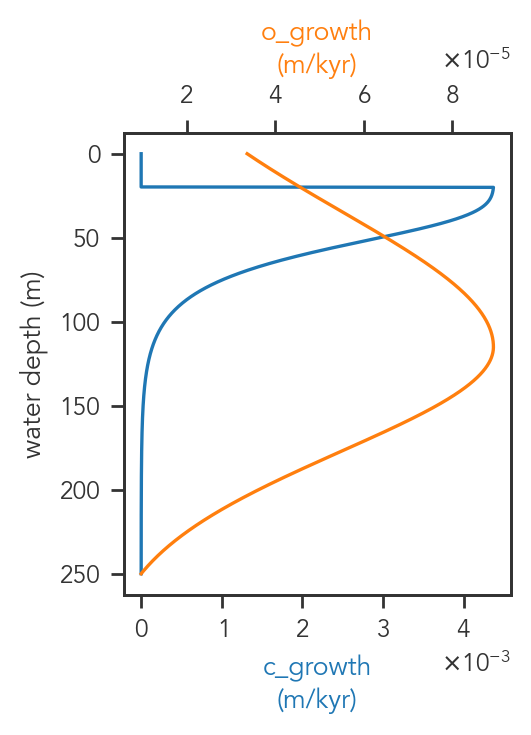

In [7]:
# setup
z = np.linspace(1e-5, 250, 1000)        # depth (m), positive down
Dt = 20                                 # tidal depth cutoff
max_TOC_percent = 2.0                   # max allowed TOC
alg_coef = 3.5                          # carbonate growth multiplier

# growth rates converted from m/yr to m/kyr (because model dt is in kyr)
Gm = Gmax = 0.00125 * alg_coef          # m/kyr, no division by 1000

# raw growth functions (unscaled)
carb_raw = lambda d: bosscher_G(d, Gm=Gm, Dt=Dt, k=0.05, Ik=200, out='growth')
org_raw = lambda d: erf_G_asym(d, Gmax=Gmax, G_depth=115, width_shallow=130, width_deep=100) # latest

# compute scaling for TOC ~2%
toc_target_frac = max_TOC_percent / 100
max_ratio = toc_target_frac / (1 - toc_target_frac)
org_scale = max_ratio * Gm / Gmax

# final scaled functions (m/kyr)
carb_growth = lambda d: carb_raw(d)
org_growth_base  = lambda d: org_raw_z(d) * org_scale
org_growth  = lambda d: org_raw(d) * org_scale

# plot 
fig, ax = plt.subplots(figsize=(2.5, 3))
ax.plot(carb_growth(z), z, label='carb', color='tab:blue')
axi = ax.twiny()
axi.plot(org_growth(z), z, label='org (asym)', color='tab:orange')
ax.set_ylabel('water depth (m)')
ax.set_xlabel('c_growth\n(m/kyr)', color='tab:blue')
axi.set_xlabel('o_growth\n(m/kyr)', color='tab:orange')
ax.invert_yaxis()
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axi.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
axi.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

print(f'Model time unit:              1 kyr')
print(f'Max TOC target:               {max_TOC_percent:.2f}%')
print(f'Final org/carb max ratio:     {max_ratio:.6f}')

In [8]:
# initial sediment proxy
wi1 = jnp.ones_like(hi) * 0.0
scale_organics = True

calculated ymin,ymax = -406.25, 205.25
mean grid dy = 6.121e-01


running model: TOC total_A0.1_ylen1000_2025-12-19 14:41:   0%|          | 0/2000 [00:00<?, ? compiled steps/s]

plotting results:   0%|          | 0/2000 [00:00<?, ? beds/s]

actual ymin,ymax = -306.00, 105.00
mean eroded distance = 1.21e-01; mean deposited distance = 5.41e-02


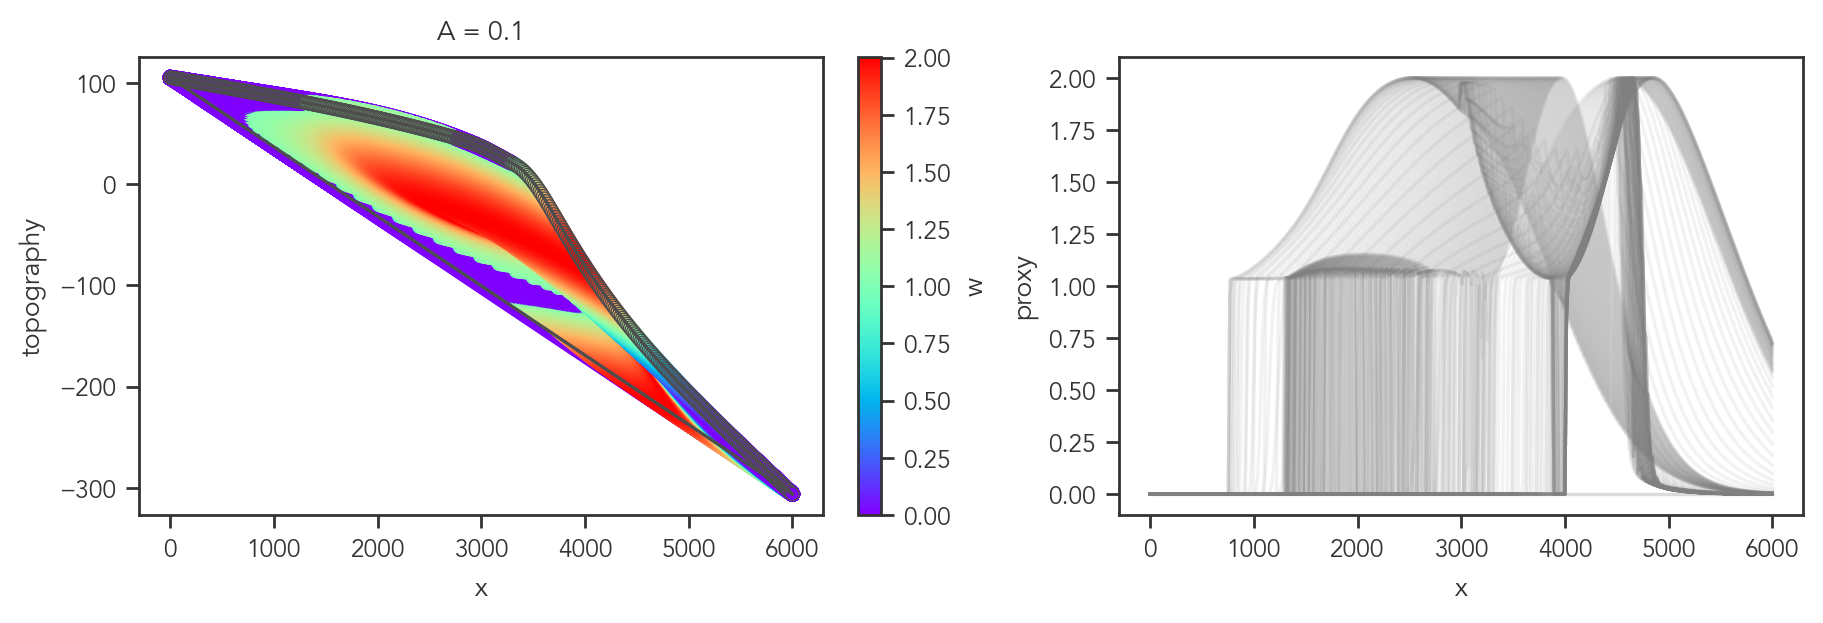

In [9]:
# run model
m1a = run(p1,                            
          model_desc = 'TOC total',                
          hi = hi,                            
          wi = wi1,                            
          sl_fun = sl_fun,                   
          sec_w_fun = sec_w_fun,           
          wi_sec = False,
          depth_w_fun = None,  
          carb_growth=True,
          org_growth=True,
          growth_fun_alg = carb_growth,     
          growth_fun_org = org_growth,                
          track_toc = True,
          scale_organics=scale_organics,
          w_set_erode = True,              
          full_storage = True,  
          storage_level = 'compiled',
          swi_dist_calc = False,
          track_react = 'respiration',
          swi_fun = None,
          w_transport=True)

im_ylen = 1000 matching grid_ylen


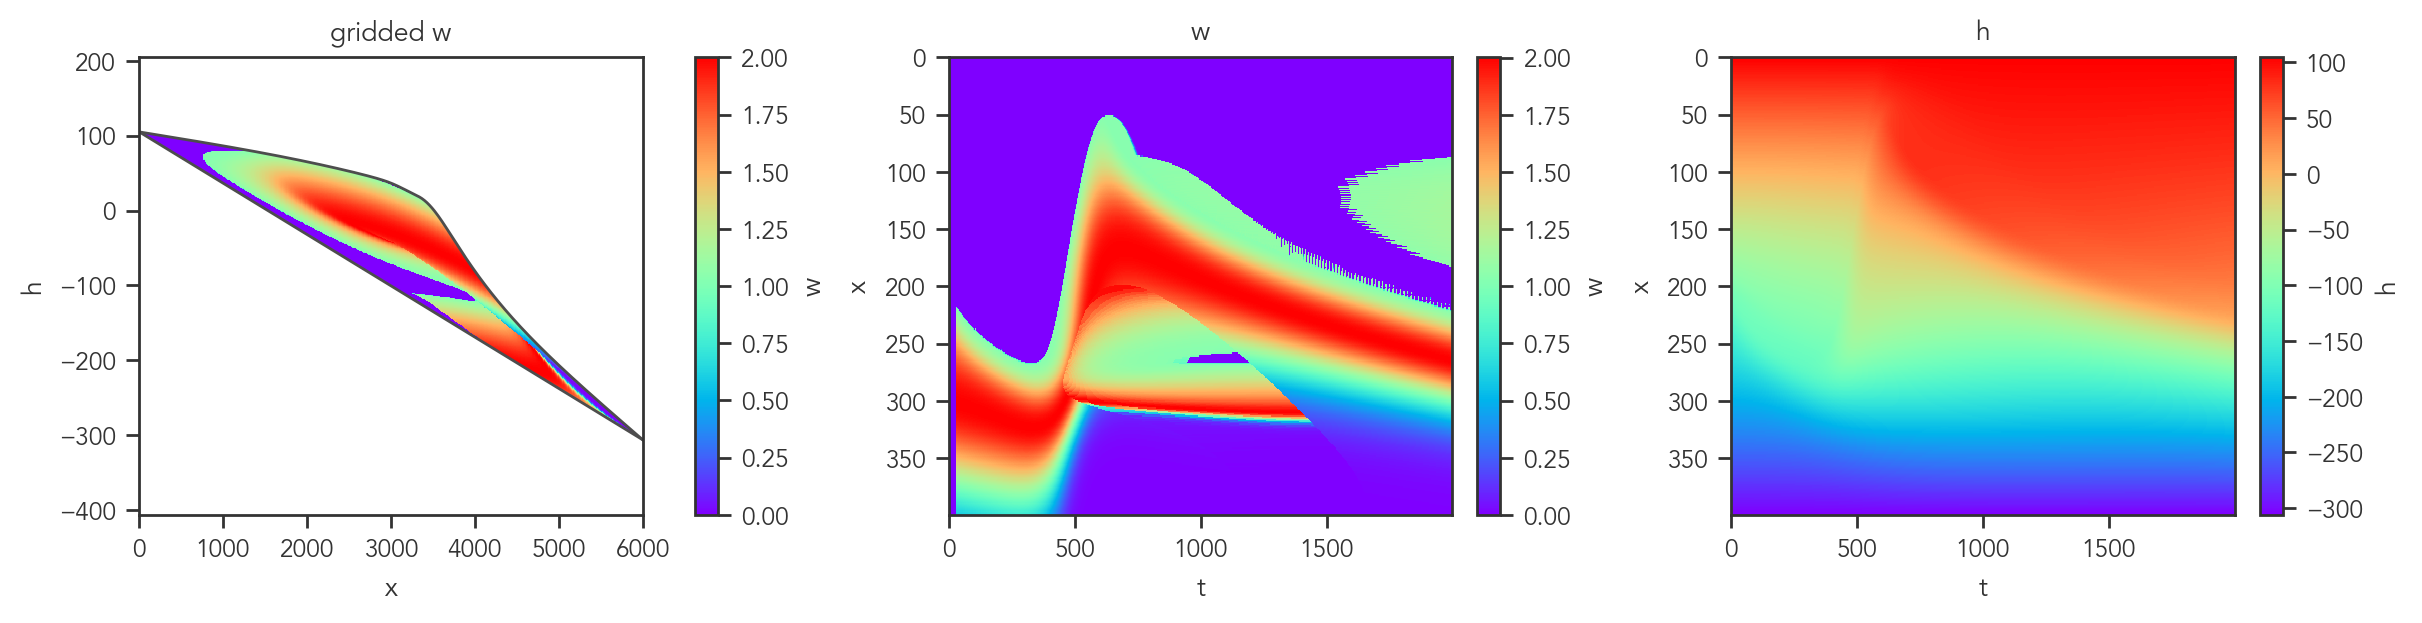

In [10]:
# reformulating for better boxplots and facies maps
facies_data = [{'name': 'Inner Shelf', 'type': 'uniform', 'max': 21.5, 'width': 0.8},
               {'name': 'Outer Shelf', 'type': 'uniform', 'min': 21.5, 'max': 35, 'width': 0.8},
               {'name': 'Upper Slope', 'type': 'uniform', 'min': 35, 'max': 75, 'width': 0.6},
               {'name': 'Middle Slope', 'type': 'uniform', 'min': 75, 'max': 110, 'width': 0.4},
               {'name': 'Lower Slope', 'type': 'uniform', 'min': 110, 'max': 145, 'width': 0.3},
               {'name': 'Deep Basin', 'type': 'uniform', 'min': 145, 'width': 0.2}]

# facies colours
facies_colours = list(sns.color_palette('coolwarm_r',n_colors=len(facies_data)-1).as_hex()) # add one as going to drop the white one; -1 as terrestrial is not here anymore
facies_colours = ['tab:red'] + facies_colours + ['tab:blue']

# model outputs
o1a = Model_output(**m1a,facies_data=facies_data,facies_colours=facies_colours,bc_filter=False,set_under_c='.3',im_ylen=None,images=True,swi_dist_calc=False)
o1a.plot_grids(cmap='rainbow')

### Run (1b): Grow TOC *with* loss to respiration (see porosity profile in Berner)

R0 = 0.000008


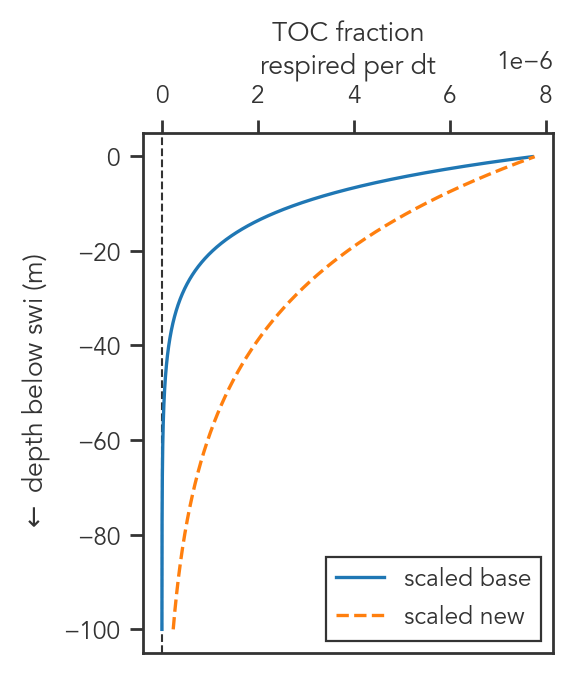

In [11]:
# compute reaction rate for respiration
trg1 = 7.5 #10 # % / Myr
R0 = compute_f_react(trg1, p1['dt']) # 10% / Myr
p1['f_react'] = R0 #0.00005   
print(f'R0 = {R0:8f}')

# how steep is curve for reaction; matches Fig 3.2 Berner porosity profile; more respiration in areas with more porespace
tau1 = 0.1 
tau2 = 0.035 # 0.035
p1['tau'] = tau2 # 0.1 #0.025 #0.1 #0.1 ; 0.4

zs = np.arange(-100, 0, 0.1)

def resp_fun(vertical_distance, d13c_seawater=1.0, base_value=0.0, tau=0.1, f_react=0.1):
    curve = (d13c_seawater * jnp.exp(tau * vertical_distance) +
             base_value * (1.0 - jnp.exp(tau * vertical_distance))) #+ 0.3 # can add this to match berner exactly
    return curve #* f_react  # scale the decay so SWI = f_react

resp_curve = resp_fun(zs, tau=tau1, f_react=p1['f_react'])
resp_curve_new = resp_fun(zs, tau=p1['tau'], f_react=p1['f_react'])

fig, ax = plt.subplots(figsize=(2.75, 3.25),layout='constrained')
ax.plot(resp_curve*p1['f_react'],zs,label='scaled base')
ax.plot(resp_curve_new*p1['f_react'],zs,ls='--',label='scaled new')

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xlabel('TOC fraction\nrespired per dt')
ax.set_ylabel(r'$\leftarrow$ depth below swi (m)');
#ax.set_ylim(-50,0) # match berner figure
ax.axvline(0,color='.2',ls='--',zorder=0,lw=0.75)
ax.legend()

calculated ymin,ymax = -406.25, 205.25
mean grid dy = 6.121e-01


running model: TOC remaining_A0.1_ylen1000_2025-12-19 14:48:   0%|          | 0/2000 [00:00<?, ? compiled step…

plotting results:   0%|          | 0/2000 [00:00<?, ? beds/s]

actual ymin,ymax = -306.00, 105.00
mean eroded distance = 1.21e-01; mean deposited distance = 5.41e-02


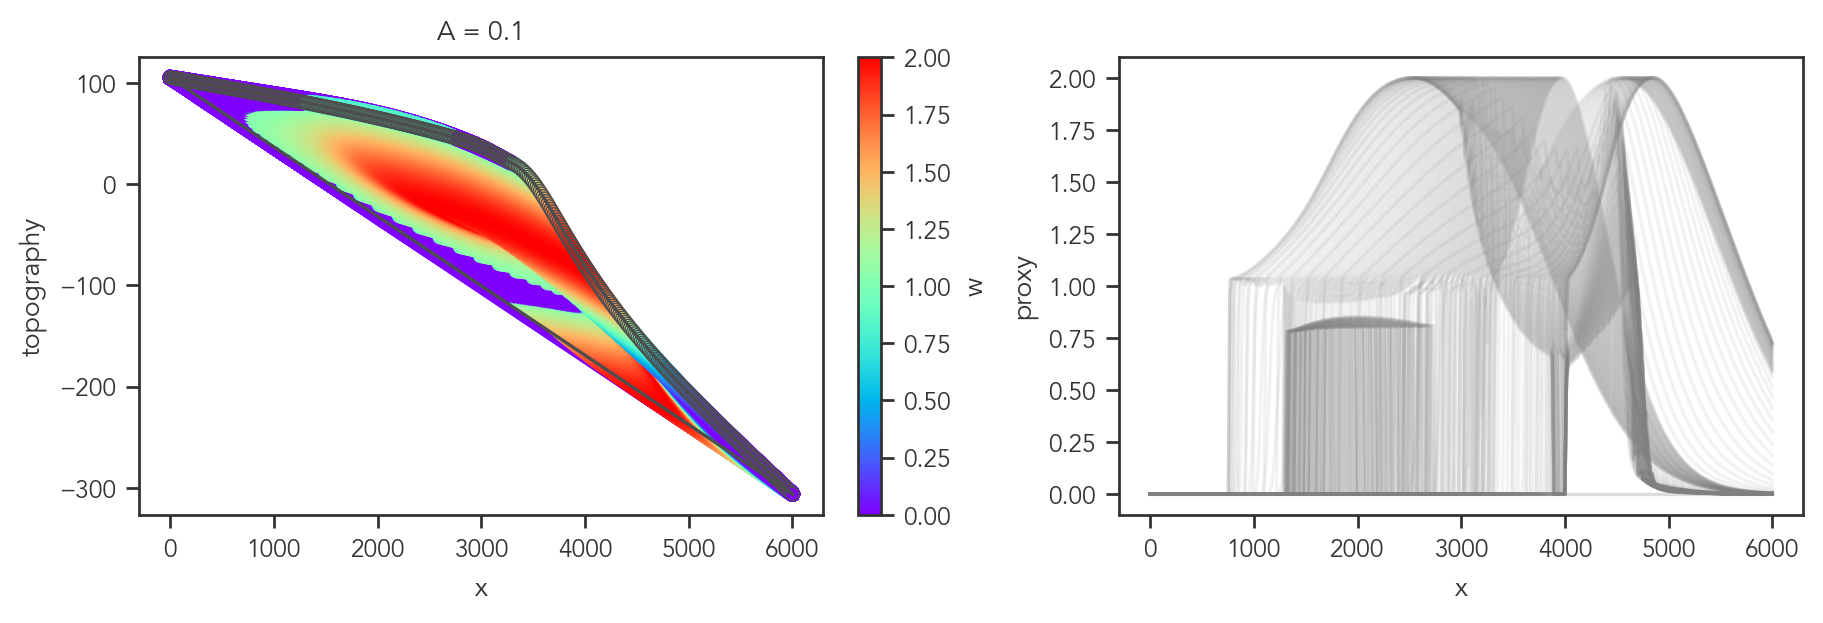

In [12]:
# run model
m1b = run(p1,                            
          model_desc = 'TOC remaining',                
          hi = hi,                            
          wi = wi1,                            
          sl_fun = sl_fun,                   
          sec_w_fun = sec_w_fun,
          wi_sec = False,
          depth_w_fun = None,  
          carb_growth=True,
          org_growth=True,
          growth_fun_alg = carb_growth,     
          growth_fun_org = org_growth,             
          track_toc = True,
          scale_organics=scale_organics,
          w_set_erode = True,              
          full_storage = True,  
          storage_level = 'compiled',
          grid_level='compiled',
          swi_dist_calc = True,
          track_react = 'respiration',
          swi_fun = resp_fun,
          porosity_fun = None,
          w_transport = True)     

im_ylen = 1000 matching grid_ylen


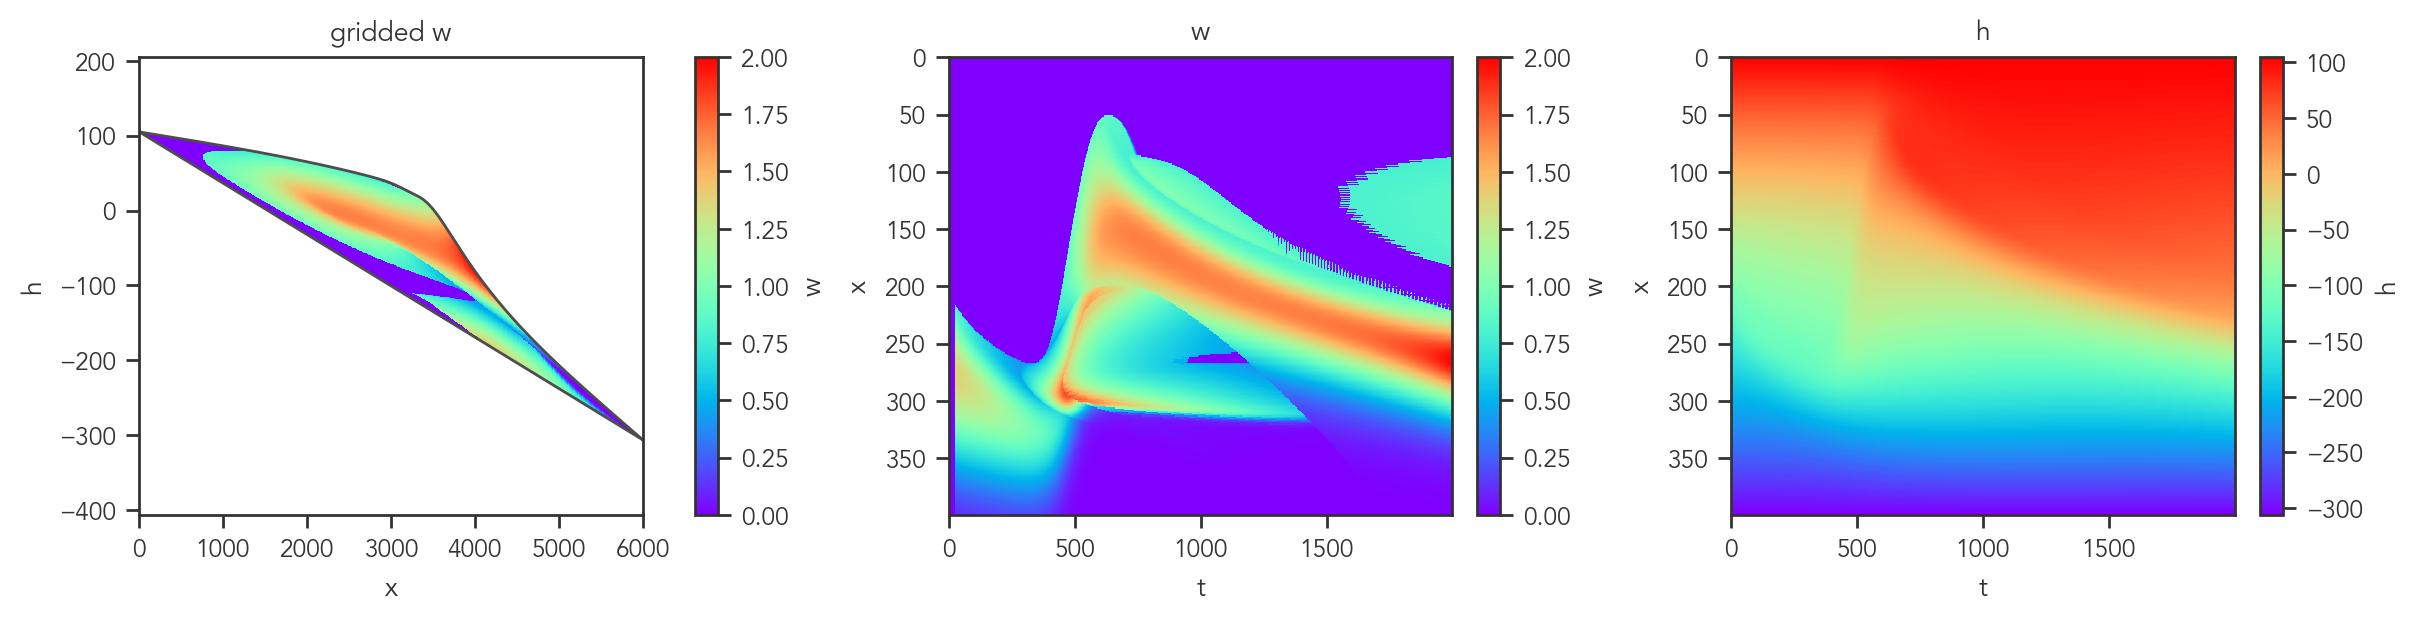

In [13]:
# model outputs
o1b = Model_output(**m1b,facies_data=facies_data,facies_colours=facies_colours,bc_filter=False,set_under_c='.3',im_ylen=None,images=True,swi_dist_calc=True)
o1b.plot_grids(cmap='rainbow')

## Determine difference between run 1a and 1b: Converting amount TOC remaining to amount TOC lost

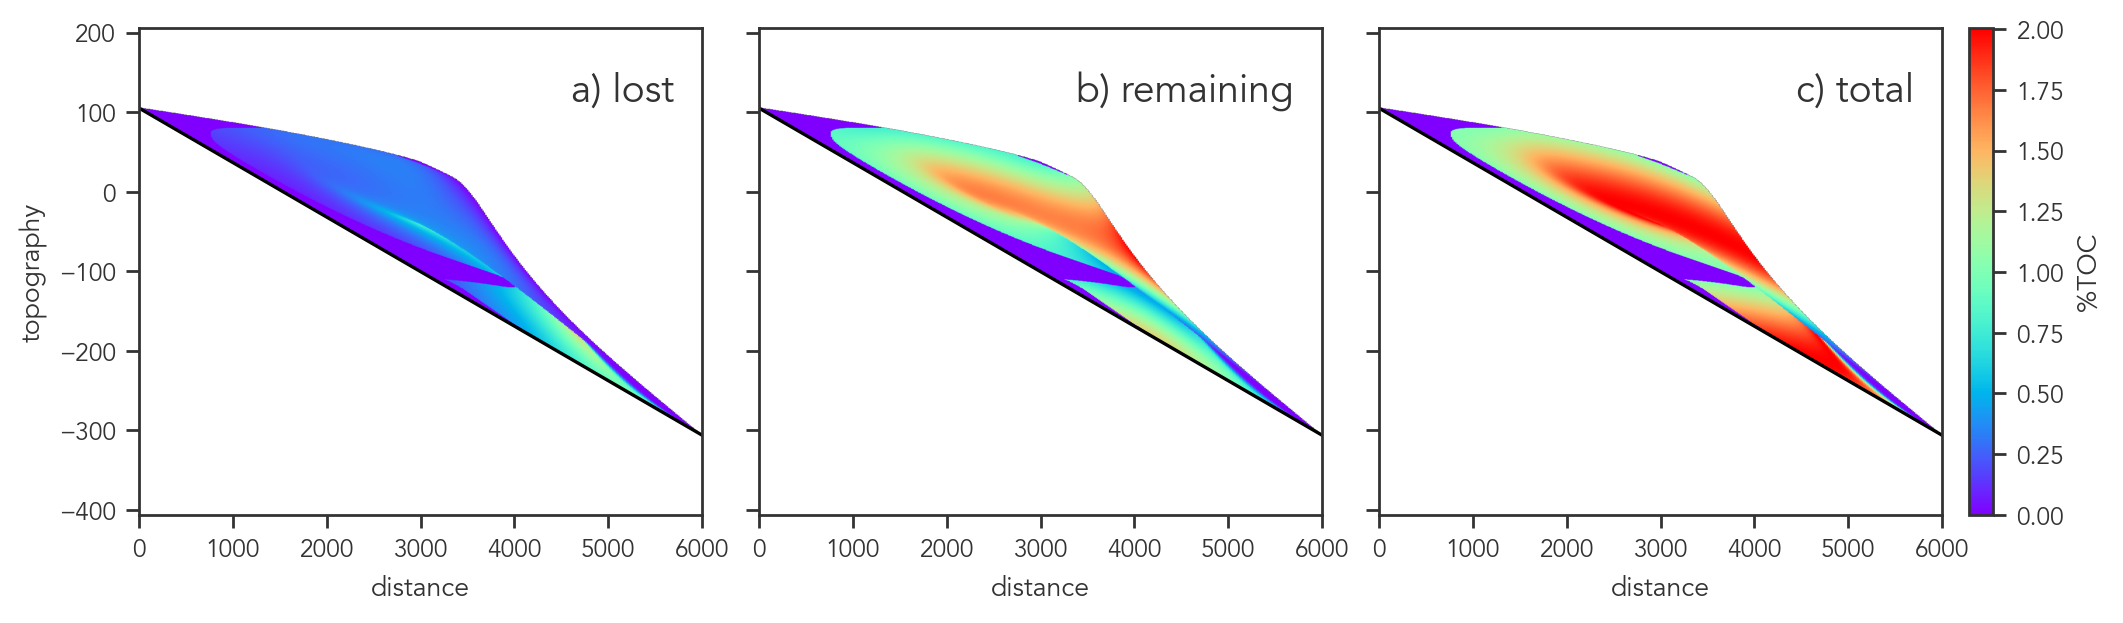

In [14]:
# TOC_loss = no_respiration - with_respiration = a - b
grid_d = o1a.gridw - o1b.gridw
grid_d = np.clip(grid_d, 0, None)            # remove erosion (negative loss)

# stack all three arrays to get global min/max
all_data = np.stack([grid_d, o1b.gridw, o1a.gridw])
vmin = np.nanmin(all_data)
vmax = np.nanmax(all_data)

# plot
fig,ax = plt.subplots(1,3,figsize=(10.5,3),sharey=True,layout='constrained')

# lost
im = ax[0].imshow(grid_d,aspect='auto',origin='upper',cmap='rainbow',extent=o1a.extent,vmin=vmin,vmax=vmax)
#plt.colorbar(im,label='%TOC loss to respiration',location='top')
ax[0].plot(x,o1a.beds[0],c='k')
#ax[0].plot(x,o1a.beds_eroded[-1],c='k')
ax[0].set_xlabel('distance')
ax[0].set_ylabel('topography')

# remain
im = ax[1].imshow(o1b.gridw,aspect='auto',origin='upper',cmap='rainbow',extent=o1a.extent,vmin=vmin,vmax=vmax)
#plt.colorbar(im,label='%TOC remaining after respiration',location='top')
ax[1].plot(x,o1a.beds[0],c='k')
#ax[1].plot(x,o1a.beds_eroded[-1],c='k')
ax[1].set_xlabel('distance')

# total
im = ax[2].imshow(o1a.gridw,aspect='auto',origin='upper',cmap='rainbow',extent=o1a.extent,vmin=vmin,vmax=vmax)
#plt.colorbar(im,label='total %TOC without respiration',location='top')
ax[2].plot(x,o1a.beds[0],c='k')
#ax[2].plot(x,o1a.beds_eroded[-1],c='k')
ax[2].set_xlabel('distance')

labs = ['a) lost','b) remaining','c) total']
for i,l in enumerate(labs):
    ax[i].text(0.95,0.85,l,transform=ax[i].transAxes,size=14,ha='right')

# shared colorbar on top
cbar = fig.colorbar(im, ax=ax[2], location='right', shrink=1, pad=0, aspect=20)
cbar.set_label('%TOC')

 # plot T-R surfaces
# for i in range(3):
#     ax[i].plot(o1b.x,o1b.beds_eroded[o1b.reg_idx,:].T,alpha=1,ls=':',label='regressive surface',color='w',lw=1);
#     ax[i].plot(o1b.x,o1b.beds_eroded[o1b.tran_idx,:].T,alpha=1,ls='--',label='transgressive surface',color='w',lw=1);

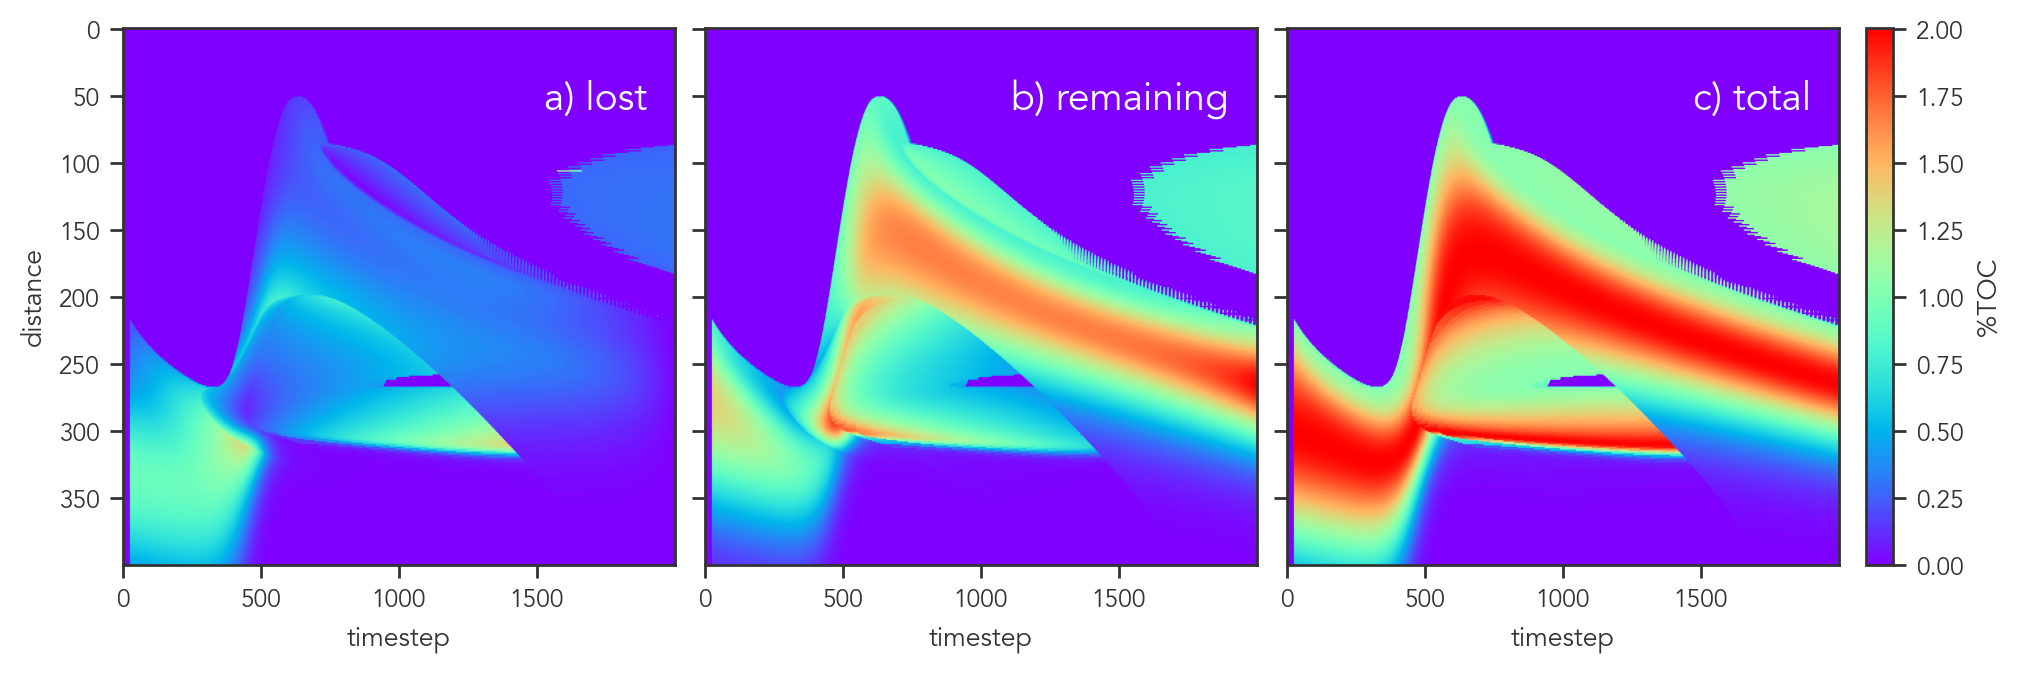

In [15]:
sto_d = o1a.sto[1::2] - o1b.sto[1::2]
sto_d = np.clip(sto_d, 0, None)            # remove erosion (negative loss)

# stack all three arrays to get global min/max
all_data = np.stack([sto_d, o1b.sto[1::2], o1a.sto[1::2]])
vmin = np.nanmin(all_data)
vmax = np.nanmax(all_data)

fig,ax = plt.subplots(1,3,figsize=(10,3.25),sharey=True,layout='constrained')

im = ax[0].imshow(sto_d,aspect='auto',cmap='rainbow',vmin=vmin,vmax=vmax)
im = ax[1].imshow(o1b.sto[1::2],aspect='auto',cmap='rainbow',vmin=vmin,vmax=vmax)
im = ax[2].imshow(o1a.sto[1::2],aspect='auto',cmap='rainbow',vmin=vmin,vmax=vmax)

labs = ['a) lost','b) remaining','c) total']
for i,l in enumerate(labs):
    ax[i].text(0.95,0.85,l,transform=ax[i].transAxes,size=14,ha='right',color='w')
    ax[i].set_xlabel('timestep')
ax[0].set_ylabel('distance')

# shared colorbar on top
cbar = fig.colorbar(im, ax=ax[2], location='right', shrink=1, pad=0.05, aspect=20)
cbar.set_label('%TOC')

### Convert TOC to mol C

Text(0, 0.5, 'x gridpoint')

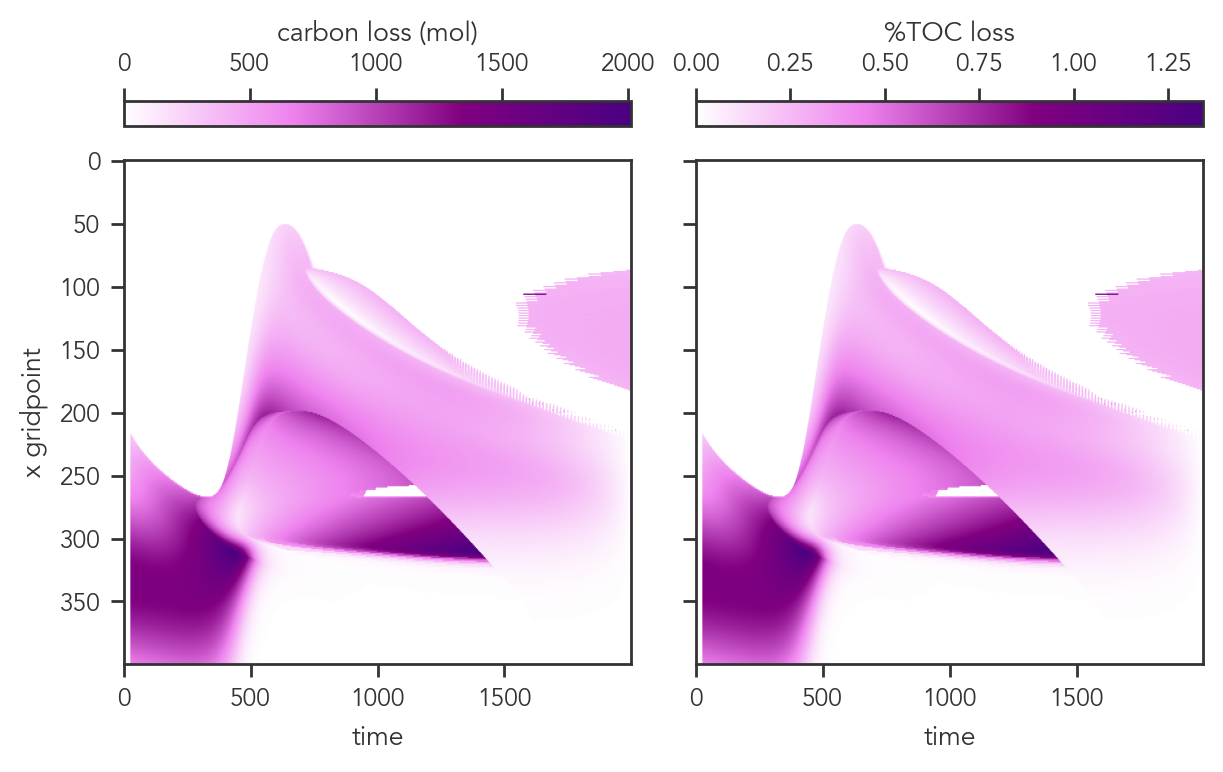

In [16]:
sed_scale = False

# extract topography and TOC data
beds_sto = o1b.sto[::2].T          # shape (Nt, Nx)
proxy_sto = sto_d                  # TOC% loss, shape (Nt, Nx)

# mask out eroded beds
beds_sto_eroded = np.minimum.accumulate(beds_sto[::-1, :], axis=0)[::-1, :]
mask_sto = (beds_sto > beds_sto_eroded)
beds_sto_eroded = np.where(mask_sto, np.nan, beds_sto)

# convert TOC% loss to mol C using new generalized function
mol_C_org, v_cm3 = calc_mol(toc_percent=proxy_sto, topo=beds_sto.T, mode='organic sediment', params=p1,frac_reactive=1,sed_scale=sed_scale) # 0.5; 0.8, 1.0

# remove eroded beds from mol_C_org using erosion mask
var = o1b.proxy_sto_eroded.T
# mol_C_org = jnp.where(jnp.isnan(var), jnp.nan, mol_C_org)
# proxy_sto = jnp.where(jnp.isnan(var), jnp.nan, proxy_sto)

#colors = ['white', 'violet', 'purple', 'black']
colors = ['white', 'violet', 'purple', 'indigo']
purps = sns.blend_palette(colors, as_cmap=True)
purps_r = sns.blend_palette(colors[::-1], as_cmap=True)

fig, ax = plt.subplots(1, 2, figsize=(6, 3.75), sharey=True, sharex=True, layout='constrained')

# mol C loss plot
im1 = ax[0].imshow(mol_C_org, aspect='auto', cmap=purps)
cb1 = plt.colorbar(im1, ax=ax[0], location='top', label='carbon loss (mol)')

# TOC % loss plot
im2 = ax[1].imshow(proxy_sto, aspect='auto', cmap=purps)
cb2 = plt.colorbar(im2, ax=ax[1], location='top', label='%TOC loss')

[ax[i].set_xlabel('time') for i in range(2)]
ax[0].set_ylabel('x gridpoint')

### Convert TOC Remaining to mol carbonate existing

molar mass of carbonate = 100.09, fraction carbon in carbonate = 0.12


Text(0.5, 1.0, 'moles C in remaining carb')

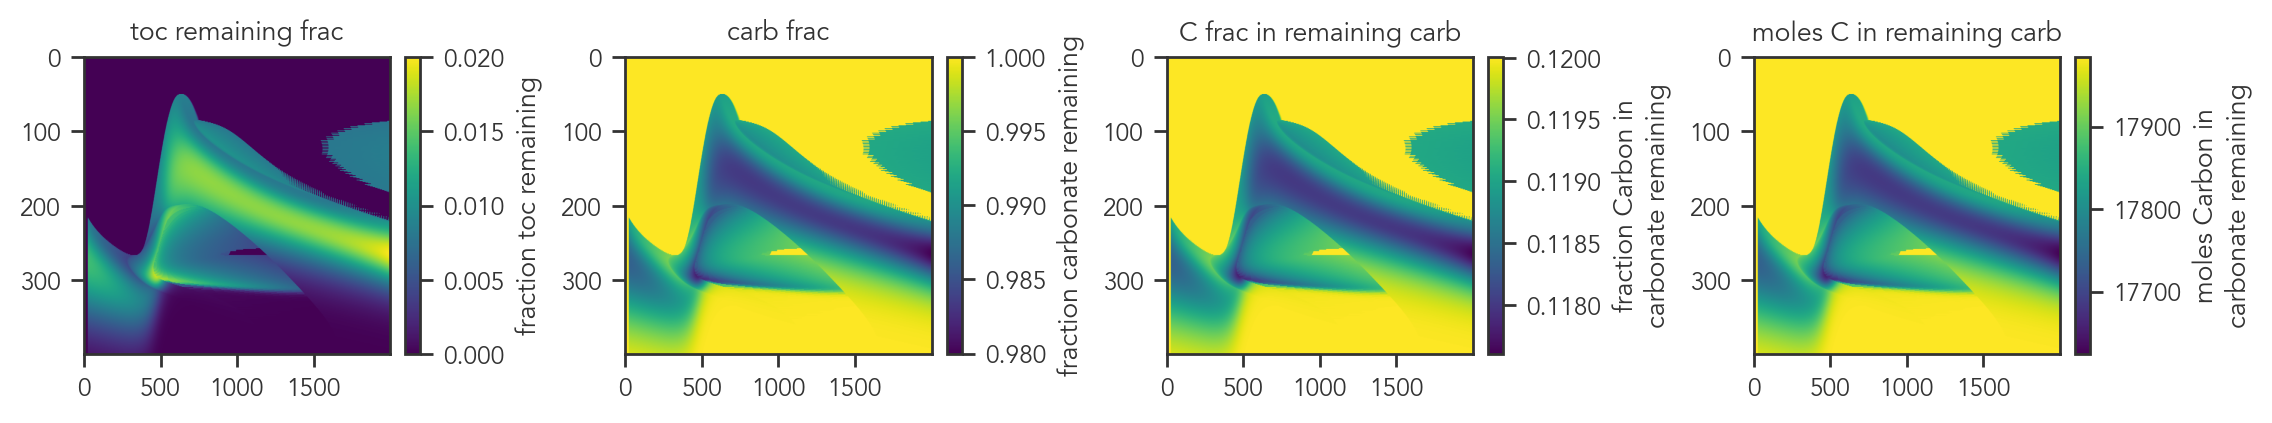

In [18]:
# extract topography and TOC data
beds_sto = o1b.sto[::2].T          # shape (Nt, Nx)
toc_rem = o1b.sto[1::2]/100         # TOC% remaining, shape (Nt, Nx) converted to fraction (0 to 1)
frac_carb = 1 - toc_rem

# molar masses
mm_Ca = 40.078 # g/mol
mm_C = 12.011 # g/mol
mm_O = 15.999 # g/mol
mm_carb = mm_Ca + mm_C + (3 * mm_O)
frac_C = mm_C / mm_carb # ~12% C in CaCO3
print(f'molar mass of carbonate = {mm_carb:.2f}, fraction carbon in carbonate = {frac_C:.2f}')

# convert remaining TOC to fraction carbon in existing carbonate sediments
frac_C = frac_carb * frac_C 

# convert to moles
mol_C_carb, _ = calc_mol(carb_frac=frac_C, topo=beds_sto.T, mode='carbonate sediment', params=p1,sed_scale=sed_scale) # 0.5; 0.8, 1.0

# visualize remaining toc
fig,ax = plt.subplots(1,4,figsize=(11.25,2),layout='constrained')

im = ax[0].imshow(toc_rem,aspect='auto',cmap='viridis')
plt.colorbar(im,label='fraction toc remaining')
ax[0].set_title('toc remaining frac')

im2 = ax[1].imshow(frac_carb,aspect='auto',cmap='viridis')
plt.colorbar(im2,label='fraction carbonate remaining')
ax[1].set_title('carb frac')

im3 = ax[2].imshow(frac_C,aspect='auto',cmap='viridis')
plt.colorbar(im3,label='fraction Carbon in\ncarbonate remaining')
ax[2].set_title('C frac in remaining carb')

im4 = ax[3].imshow(mol_C_carb,aspect='auto',cmap='viridis')
plt.colorbar(im4,label='moles Carbon in\ncarbonate remaining')
ax[3].set_title('moles C in remaining carb')

## Test: manual check for maximum excursion end-member mass balance with just carbonate and organics

- As the most negative part of the basin is deeper down slope and we want -12 at upper bit, I can show what TOC% is required for -12, but makee it a bit more negative to -15 so that I can get -12 where i want but all I need to report is for -12

In [22]:
def toc_delta(d_targ, d_sw, ep=p1['ep'], ec=0, f_carb=1.0):
    """
    solve for molar balance coefficients
    """
    d_org = d_sw + ep
    d_carb = d_sw + ec
    A = mol_C_carb * f_carb
    B = mol_C_org
    T = d_targ

    with np.errstate(divide='ignore', invalid='ignore'):
        denom = B * (T - d_org)
        numer = A * (d_carb - T)
        m_needed = numer / denom

    valid = (B > 0) & np.isfinite(m_needed) & (denom != 0) & (m_needed >= 0)
    org_mult = np.nanmin(m_needed[valid])
    return org_mult

org_mult = toc_delta(d_targ=-15,d_sw=0)

# recompute fields using this org_mult
d_sw = 0.0 # ‰
#d_sw = 5.0 # ‰ 
ep = p1['ep']
ec = 0.0
d_org = d_sw + ep
d_carb = d_sw + ec
n_org = mol_C_org * org_mult
n_carb = mol_C_carb  # unchanged

d13c_max = (n_carb * d_carb + n_org * d_org) / (n_carb + n_org)
d13c_diff_max = d_carb - d13c_max


Text(0, 0.5, '$x$')

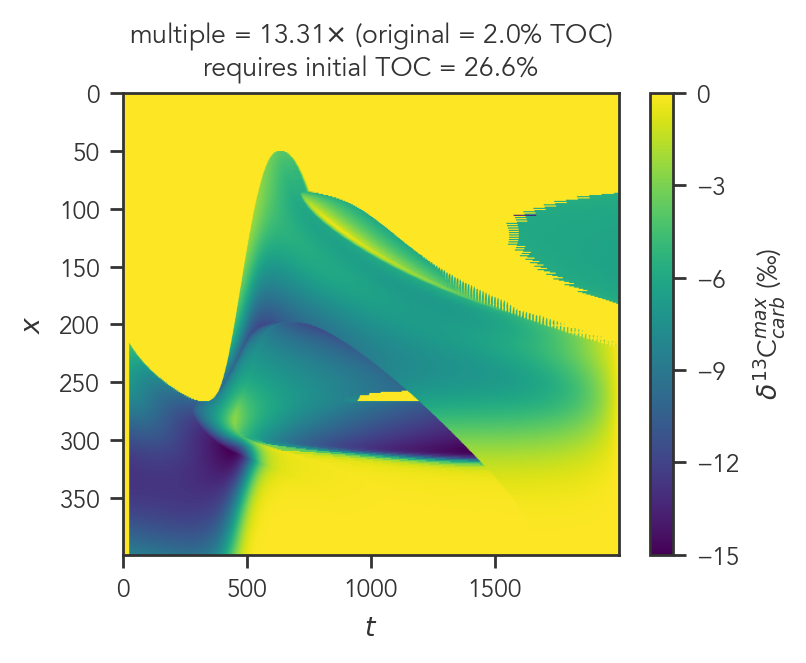

In [23]:

# balance
d13c_max = (n_carb * d_carb + n_org * d_org) / (n_carb + n_org)
d13c_diff_max = d_carb - d13c_max

r = n_org / (n_org + n_carb) # ratio of organics to total moles

d13c_solve = d13c_max
#var = d13c_diff_max
#var = r

fig,ax = plt.subplots(figsize=(4,3))
im = ax.imshow(d13c_solve,aspect='auto',cmap='viridis')
cbar = plt.colorbar(im,label='$\\delta^{13}$C$^{max}_{carb}$ (‰)')
cbar.ax.set_yticks(np.linspace(np.nanmin(d13c_solve),np.nanmax(d13c_solve),6))
ax.set_title(f'multiple = {org_mult:.2f}$\\times$ (original = {max_TOC_percent}% TOC)\nrequires initial TOC = {max_TOC_percent*org_mult:.1f}%')
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')

# End-member version: make all arrays based on my molar balance above

In [24]:
sto2 = d13c_solve
grid2 = img(sto2.T,o1b,ylen=1000)
print(sto2.shape)

(400, 2000)


### Demonstration Figure for main text

NameError: name 'csed_log' is not defined

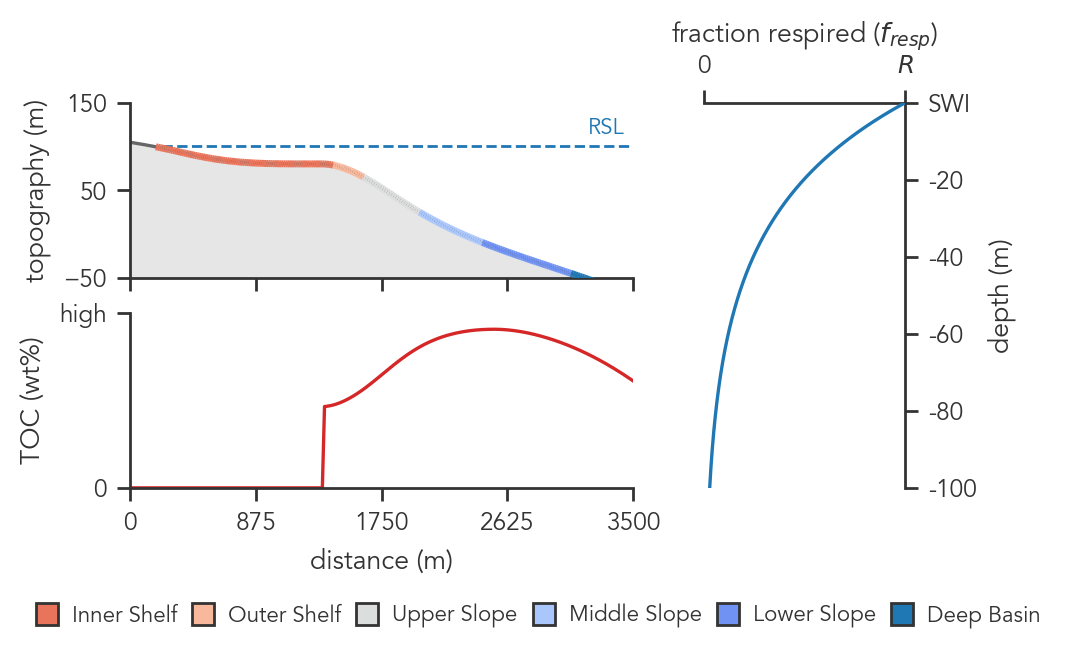

In [25]:
fig,ax = plt.subplot_mosaic(
    """
    ac
    bc
    """,figsize=(5,2.5),width_ratios=(1,.4))

a = list(ax)

# fig,ax = plt.subplot_mosaic(
#     """
#     ac.d
#     bc.d
#     """,figsize=(9,2.5),width_ratios=(1,.4,.1,.8))

a = list(ax)

# basin snapshot
tidx = 725 #1370 
bed = o1a.beds[tidx]
ax['a'].plot(o1a.x,bed,color='.4')
ax['a'].set_xlim(0,3500)
ax['a'].set_xticks(np.linspace(0,3500,5))
ax['a'].set_ylim(-50,150)
ax['a'].set_yticks(np.linspace(-50,150,3))
ax['a'].set_ylabel('topography (m)')
ax['a'].tick_params(axis='x', which='both', bottom=True, labelbottom=False)
ax['a'].fill_between(o1b.x, bed, y2=min(bed), color='.9')

# rsl
rsl = o1a.rsl_strat[tidx]
shore = o1b.sl[tidx]
ax['a'].hlines(y=rsl,xmin=shore,xmax=o1a.x[-1],zorder=0,ls='--',lw=1)

# coloured line
# compute depth and mask land
depth = rsl - bed
depth = np.where(depth > 0, depth, np.nan)

# build segments
x_vals = o1a.x
y_vals = bed
points = np.array([x_vals, y_vals]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# assign color to each segment based on depth
segment_colors = []
valid_segments = []

for i in range(len(segments)):
    d1, d2 = depth[i], depth[i+1]
    if np.isnan(d1) or np.isnan(d2):
        continue  # skip land or invalid
    avg_depth = 0.5 * (d1 + d2)
    for facies in o1b.facies_data[1:]:
        color = facies['colour']
        if facies['min'] <= avg_depth < facies['max']:
            valid_segments.append(segments[i])
            segment_colors.append(color)
            break

# plot colored topography
lc = LineCollection(valid_segments, colors=segment_colors, linewidths=2.5, zorder=10000)
ax['a'].add_collection(lc)

# TOC environments
ax['b'].sharex(ax['a'])
ax['b'].set_xlabel('distance (m)')

# calculating TOC with my masks and bias 
rsl = o1a.rsl_strat[tidx]
bed = o1a.beds[tidx]
depth = rsl - bed
mask = depth > 0
cg = o1a.csed_sto[:,tidx]
sed_rate_norm = cg / np.nanmax(cg + 1e-12)
og = org_growth(depth)
G_org = og * sed_rate_norm
h_org = np.where(mask, np.abs(G_org), 0.0)

h_carb = cg
tot_sed = h_org + h_carb + 1e-12
val = (h_org / tot_sed) 
toc = np.where(tot_sed > 0, val, 0.0)

ax['b'].plot(o1a.x,toc,color='tab:red',label='slope bias')
ax['b'].set_ylabel('TOC (wt%)')
max_ng = np.nanmax(toc)
rounded_max = round(max_ng , 4)  # rounds mantissa to 1 decimal
ax['b'].set_ylim(0,rounded_max+0.00025)
ax['b'].set_yticks([0,rounded_max+0.00025],['0','high'])

# format
for i,j in enumerate(a):
    if j not in ['c','d']:
        ax[j].spines[['right','top']].set_visible(False)

# loss rate plot
ax['c'].yaxis.tick_right()  
ax['c'].yaxis.set_label_position('right')
ax['c'].xaxis.tick_top()  
ax['c'].xaxis.set_label_position('top')
ax['c'].spines[['left','bottom']].set_visible(False)
ax['c'].plot(resp_curve_new , zs, label='$R$', color='tab:blue',ls='-',zorder=1000000)
ax['c'].set(xlabel='fraction respired ($f_{resp}$)', ylabel='depth (m)', ylim=(-100, 0), xlim=(0, 1))

# replace 0m with swi label
ax['c'].set_ylim(top=0)
yticks = ax['c'].get_yticks()
yticklabels = [f'{int(t)}' if t != 0 else 'SWI' for t in yticks]
ax['c'].set_yticks(yticks) # needs to be here to suppress warning
ax['c'].set_yticklabels(yticklabels);

# replace 1 with R
ax['c'].set_xlim(right=1)
xticks = [0,1] #ax['c'].get_xticks()
#xticklabels = [f'{int(t)}' if t != 1 else '$R$' for t in xticks]
xticklabels=['0','$R$']
ax['c'].set_xticks(xticks) # needs to be here to suppress warning
ax['c'].set_xticklabels(xticklabels);

# generate dummy scatter handles with circle markers for the legend
elabs = [i['name'] for i in o1b.facies_data][1:] # skip terrestrial
colors = facies_colours[1:] # skip terrestrial

legend_handles = [
    plt.Line2D([], [], marker='s', color='none', markerfacecolor=c, markeredgecolor='.2',
               markersize=8, label=l)
    for c, l in zip(colors, elabs)]

ax['a'].legend(
    handles=legend_handles,
    frameon=False,
    loc=1,
    bbox_to_anchor=(1.85, -1.75),
    ncols=len(elabs),
    handlelength=0.75,
    handletextpad=0.75,
    columnspacing=0.8,
    fontsize=8)

# label rsl
ax['a'].text(0.91,0.825,'RSL',color='tab:blue',fontsize=8,transform=ax['a'].transAxes)

# inset 
#axi = ax['b'].inset_axes([0.14,0.4,0.2,0.6])

# choose how many points to keep
n_keep = 2000 # 2000

# choose random indices and sort to preserve original order
idx = np.sort(np.random.choice(len(csed_log), n_keep, replace=False))

# downsampled data (full scatter makes a large image and slow latex compile)
subset_csed_log, subset_toc_log = csed_log[idx], toc_log[idx]
#subset_csed_log, subset_toc_log = csed_log, toc_log

# axi.tick_params(length=0,labelsize=5)
# axi.scatter(subset_csed_log,subset_toc_log,fc='tab:blue',ec='none',s=2)
# axi.set_xlabel('log$_{10}$\n$q_{carb}$ (m/kyr)',fontsize=6,labelpad=-5)
# axi.set_ylabel('log$_{10}$\nTOC (wt%)',fontsize=6,labelpad=-5)
# axi.set_xlim(-10,-1)
# axi.set_xticks(np.linspace(-10,-1,2))
# axi.set_ylim(-4,1)
# axi.set_yticks(np.linspace(-4,1,2))
# axi.spines[['right','top']].set_visible(False)
# axi.xaxis.set_major_formatter(ticker.FuncFormatter(plain_power_format))
# axi.yaxis.set_major_formatter(ticker.FuncFormatter(plain_power_format))
# axi.text(0.8,0.15,'d)',transform=axi.transAxes)

# label abc
# labels = ['a)', 'c)', 'd)', 'b)']
# for i, label in zip(a,labels):
#     xi = 0.05 #if i != 'c' else 0.1
#     #xi = xi if i!='b' else 0.95
#     ax[i].text(xi, 0.875, label, transform=ax[i].transAxes, fontsize=14)

# label abc
labels = ['a)', 'c)', 'b)']
for i, label in zip(a,labels):
    xi = 0.05 if i != 'c' else 0.1
    #xi = xi if i!='b' else 0.95
    ax[i].text(xi, 0.875, label, transform=ax[i].transAxes, fontsize=14)

## Supplement basin maps

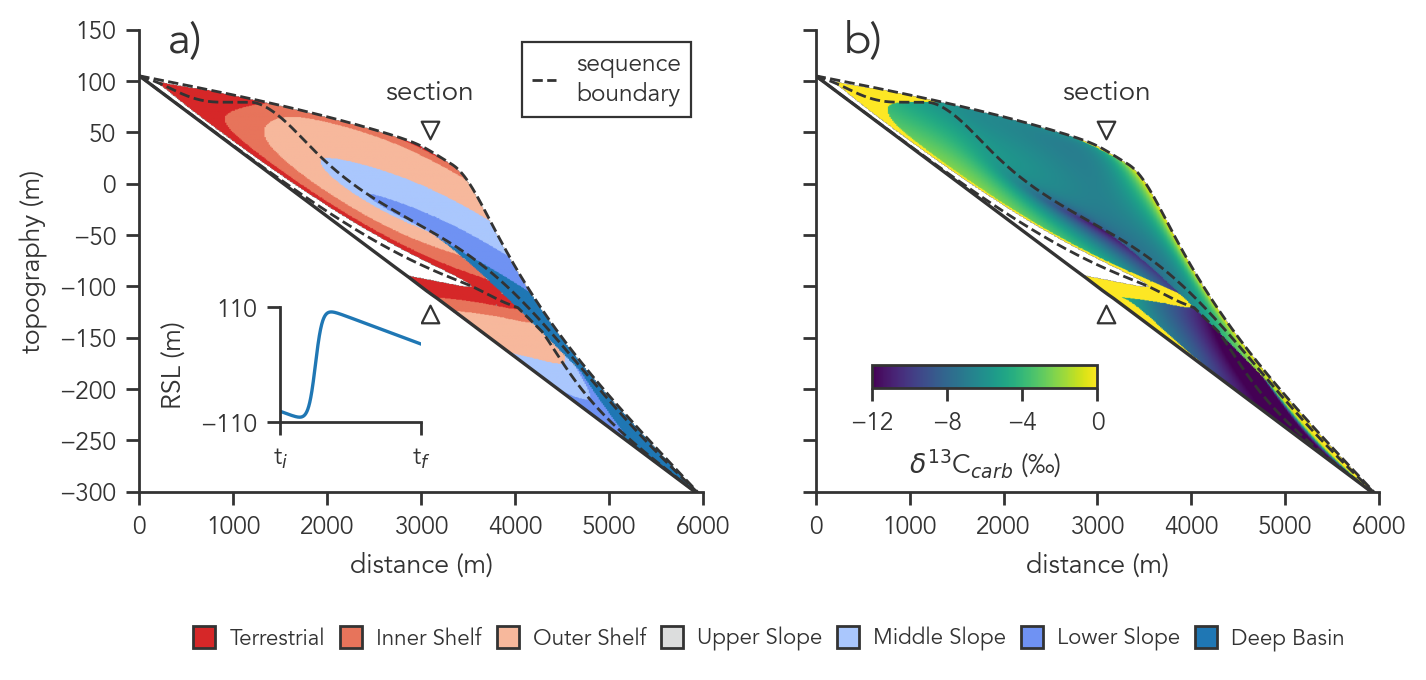

In [675]:
fig,ax = plt.subplots(1,2,figsize=(8,3),sharey=True)#,layout='constrained')

# facies
facies_data1 = np.where(o1b.facies_pred == 0, np.nan, o1b.facies_pred)
fim = ax[0].imshow(facies_data1,cmap=o1b.cmap,origin='lower',aspect='auto',extent=o1b.extent)

for i in range(2):
    ax[i].set_xlabel('distance (m)')

    # seqs
    ax[i].plot(o1b.x,o1b.beds[o1b.reg_idx,:].T,alpha=1,ls='--',color='.2',lw=1);
    ax[i].plot(o1b.x,o1b.beds_eroded[o1b.tran_idx,:].T,alpha=1,ls='--',color='.2',lw=1);
    ax[i].plot(o1b.x,o1b.beds_eroded[-1,:].T,alpha=1,ls='--',color='.2',lw=1,label='sequence\nboundary');
    ax[i].plot(o1b.x, o1b.beds[0], color='.2')

    # format basin ax
    ax[i].set_xlim(0,6000)
    ax[i].set_ylim(-300,150)
    ax[i].spines[['top','right']].set_visible(False)

ax[0].legend(loc=1,handlelength=1)


core_idx = 206 # chosen x-grid location for "drill core"
locs2 = o1b.Nx_toX(core_idx, out='grid')
for i in range(2):
    ax[i].scatter(x=locs2,y=o1b.beds_eroded[-1,core_idx]+20,marker='v',fc='w',ec='.2',s=40)
    ax[i].scatter(x=locs2,y=o1b.beds_eroded[0,core_idx]-20,marker='^',fc='w',ec='.2',s=40)
    ax[i].text(locs2,o1b.beds_eroded[-1,core_idx]+50,'section',ha='center',fontsize=10)

# isotopes
d13c1 = np.where(o1b.facies_pred == 0, np.nan, grid2)
cim = ax[1].imshow(d13c1,cmap='viridis',origin='lower',aspect='auto',extent=o1b.extent,vmin=-12)

# inset for d13c colorbar
axii = ax[1].inset_axes([0.1,0.225,0.4,0.05])
cb2 = plt.colorbar(cim,cax=axii,orientation='horizontal',label='$\\delta^{13}$C$_{carb}$ (‰)')
cb2.ax.set_xticks(np.linspace(-12,d_sw,4));

# inset for rsl
axi = ax[0].inset_axes([0.25,0.15,0.25,0.25])
axi.plot(o1b.rsl_strat)
axi.set_xticks([0,2000],['t$_i$','t$_f$'])
axi.set_xlim(0,2000)
axi.set_ylim(-110,110)
axi.set_yticks([-110,110])
axi.spines[['top','right']].set_visible(False)
axi.set_ylabel('RSL (m)')

# label a,b
labs = ['a)','b)']
for i,j in enumerate(labs):
    ax[i].text(0.05,0.95,j,transform=ax[i].transAxes,fontsize=16)

# label y
ax[0].set_ylabel('topography (m)')

# generate handles, including terrestrial here (supp fig)
elabs1 = [i['name'] for i in o1b.facies_data]#[1:] # skip terrestrial
colors1 = facies_colours#[1:] # skip terrestrial

legend_handles1 = [
    plt.Line2D([], [], marker='s', color='none', markerfacecolor=c, markeredgecolor='.2',
               markersize=8, label=l)
    for c, l in zip(colors1, elabs1)]

ax[1].legend(
    handles=legend_handles1,
    frameon=False,
    loc=1,
    bbox_to_anchor=(0.975, -0.25),
    ncols=len(elabs1),
    handlelength=0.75,
    handletextpad=0.75,
    columnspacing=0.8,
    fontsize=8)


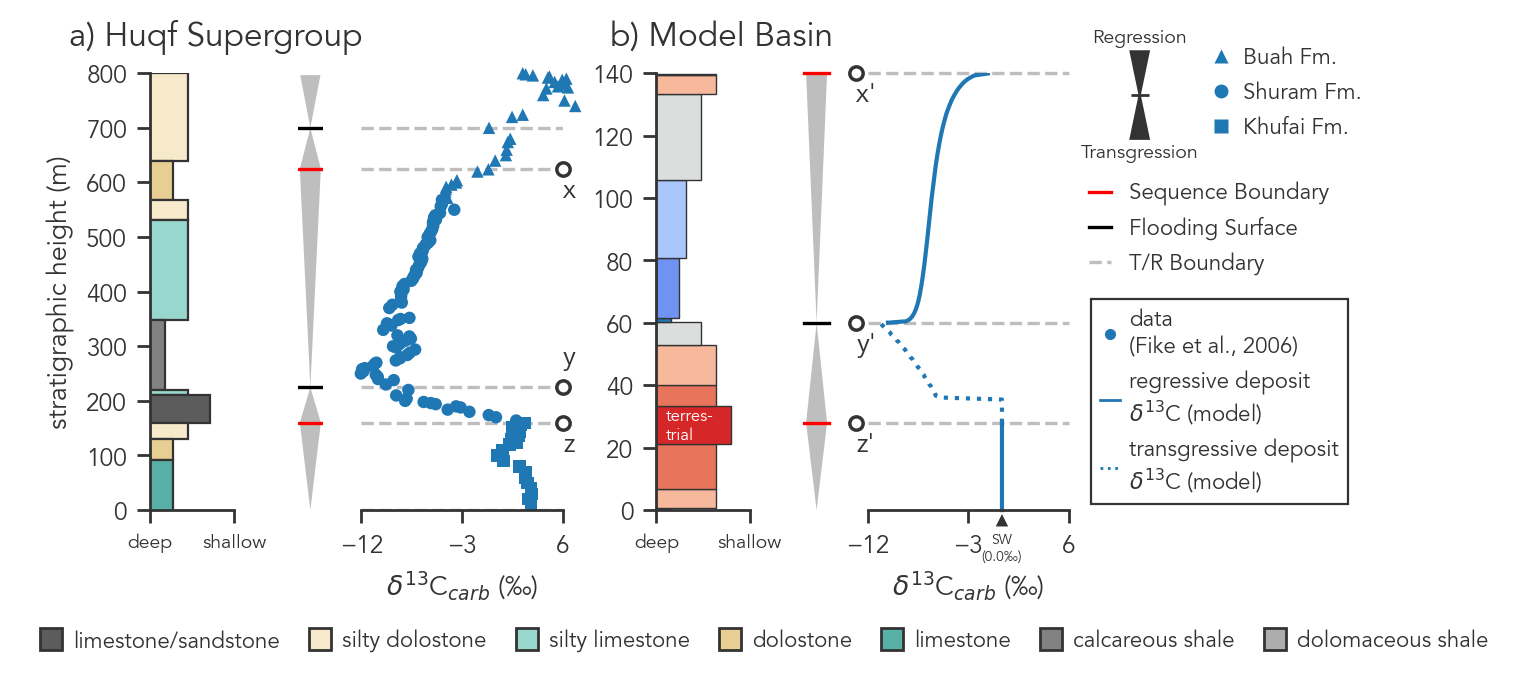

In [43]:
fig, ax = plt.subplots(1, 6, figsize=(6, 3), sharey=False, width_ratios=[0.65, 0.125, 1, 0.65, 0.125, 1], layout='constrained')

# d13c_lims
dmin = -12
dmax = 6
  

# model strat
core_idx = 216 #216 #206 # chosen x-grid location for "drill core"

# strat column for model
targ_val, new_y_val, y_min, y_max, seq_y = o1b.strat_col_im(
    core_idx, targ=grid2, out=True, plot=True, ax=ax[3],
    x_axis=False, seq_bounds=True,edgecolor='.2')
ax[3].set_xticks([])
ax[3].spines[['top', 'bottom', 'right']].set_visible(False)
ax[3].set_xlim(0, 1.75)
ax[3].set_ylim(0,140)

# turn off spacer 2 ticks
ax[4].sharey(ax[3])
ax[4].tick_params(labelleft=False, left=False, length=0)

# model d13c
ax[5].sharey(ax[3])
ax[5].tick_params(labelleft=False, left=True)
ax[5].set_xlim(dmin,dmax)
ax[5].set_xticks(np.linspace(dmin, dmax, 3))
carb = np.flipud(grid2[:, core_idx])
o1b.tr_bars(
    loc=core_idx, ax=ax[5], xval=targ_val, yval=new_y_val, line=True,
    lines=['-', ':'], colors=['tab:blue','tab:blue'] * 2, alpha=1, legend=False, edgecolor='w', lw=1.5, # ['-', ':']
    xticks=True, zorder=1,clip=False)
ax[5].spines[['right', 'left', 'top']].set_visible(False)
ax[5].set_xlabel('$\\delta^{13}$C$_{carb}$ (‰)')

# model seq boundaries
seq_y = np.append(seq_y, 140)#-3) # add last timestep as that will be a sequence boundary; subtract to account for linewidth
for s in seq_y:
    color = 'r' if s!= seq_y[1] else 'k'
    #ax[3].scatter(x=1.25, y=s, color='r', s=20, marker='<')
    #ax[3].axhline(s,xmin=0,xmax=0.7, color='r',zorder=20000,ls='--')
    ax[4].axhline(s, color=color,zorder=20000,ls='-',clip_on=False)
    #if s!=seq_y[-1]:
    ax[5].axhline(s,color='tab:grey',zorder=0,ls='--',alpha=0.5,clip_on=False)